In [1]:
import bmxdata
import numpy as np
from numpy.fft import rfft, irfft
import matplotlib.pyplot as plt
import gc
from scipy.optimize import leastsq

%matplotlib inline

In [2]:
da=bmxdata.BMXRingbuffer('/astro/u/anze/data/longbmx/190411_130707_D1.ring')

Loading version: 1
Ncards: 2 Size: 2147483648


In [3]:
fftcache={}

In [107]:
def getPS (self, stream='datad0c1',fftpow=25, numin=1419.00, numax=1422.50, fftavg=512, 
                   ndxmin=0, ndxmax=-1, rate=1.1e3, indices=False,killspikes=False, 
                   killavg=512,killfact=9, killbuf=60):
            data=getattr(self,stream)
            fftsize=2**fftpow
            numin_,numax_=numin,numax
            nunyq=rate/2;
            dnu=nunyq/(fftsize/2+1);
            if ndxmax<=0:
                ndxmax=len(data)//fftsize
            while (abs(numin)>nunyq): numin=numin-rate
            while (abs(numax)>nunyq): numax=numax-rate
            numin=abs(numin);
            numax=abs(numax);
            if (numax<numin): numin,numax=numax,numin
            print ("   Frequencies %f - %f Mhz appear as %f - %f \n"%(numin_,numax_,numin,numax))
            imin=int(numin/dnu)
            if (imin==0): imin=1;
            imax=int(numax/dnu)
            pssize1=(imax-imin)//fftavg
            if ((imax-imin)%fftavg>0): pssize1+=1;
            imax=imin+pssize1*fftavg
            freq=np.arange(imin+fftavg/2,imax,fftavg)*dnu+rate
            out=[]
            for istart in range(ndxmin,ndxmax):
                #print ("%i/%i..."%(istart,(ndxmax-ndxmin)),end="")
                cachekey=(fftpow,istart)
                if cachekey not in fftcache:
                    fftcache[cachekey]=rfft(data[istart*fftsize:(istart+1)*fftsize])
                fft=fftcache[cachekey]
                ps=abs(fft[imin:imax]**2)
                del fft
                gc.collect()
                if (killspikes>0):
                    yts=ps.reshape((-1,killavg)).mean(axis=1)
                    yavg=0.5*(yts[0:-2]+yts[2:])
                    yts[1:-1]=yavg
                    yts=np.outer(yts,np.ones(len(ps)//len(yts))).flatten()
                    for i in np.where(ps>yts*killfact)[0]:
                        #if (abs(imin+i-9788087)<20):
                        #    print (imin+i,i%256,end="  ")
                        ps[i-killbuf:i+killbuf+1]=np.nan
                    tkill=np.sum(np.isnan(ps))
                    print ("Killed: %i/%i = %f %%"%(tkill,imax-imin,100*tkill/(imax-imin)))
                if fftavg>1:
                    ps=np.nanmean(ps.reshape((-1,fftavg)),axis=1)
                out.append(ps)
                
                
            out=np.array(out)
            if indices:
                return np.arange(imin,imax), out
            else:
                return freq,out

In [73]:
numin,numax=1419.50,1422.
freq,ps=getPS(da,ndxmax=64,numin=numin,numax=numax,fftavg=256, killspikes=False)
freqk,psk=getPS(da,ndxmax=64,numin=numin,numax=numax,fftavg=256,killavg=128,killspikes=True,killbuf=10,killfact=10)

   Frequencies 1419.500000 - 1422.000000 Mhz appear as 319.500000 - 322.000000 

   Frequencies 1419.500000 - 1422.000000 Mhz appear as 319.500000 - 322.000000 



   Frequencies 1512.500000 - 1520.000000 Mhz appear as 412.500000 - 420.000000 

   Frequencies 1512.500000 - 1520.000000 Mhz appear as 412.500000 - 420.000000 



/astro/u/anze/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


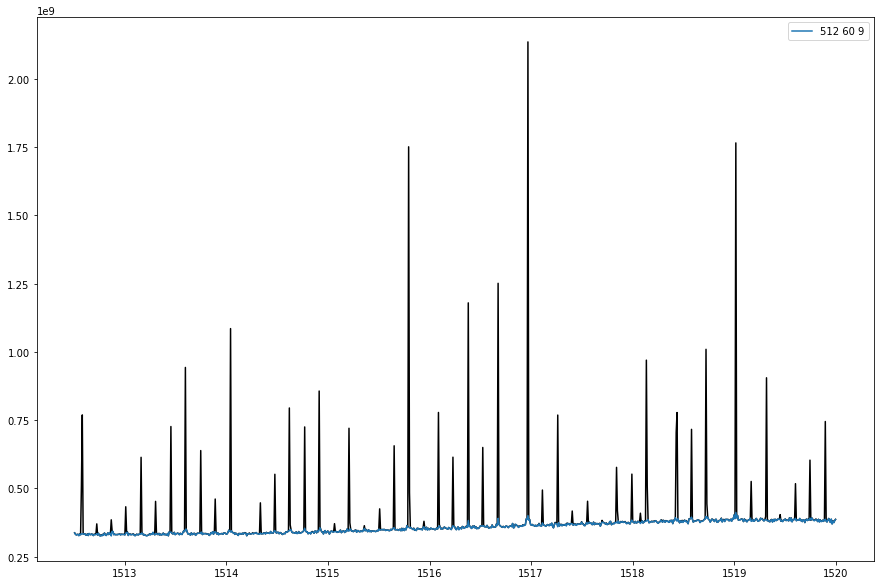

In [74]:
numin,numax=1512.50,1520.
freq,ps=getPS(da,ndxmax=64,numin=numin,numax=numax,fftavg=256, killspikes=False)
plt.figure(figsize=(15,10))
plt.plot(freq,ps.mean(axis=0),'k-')
for killavg in [512]:
    for killbuf in [60]:#,30,50]:
        for killfact in [9]:#,12]:
            freqk,psk=getPS(da,ndxmax=64,numin=numin,numax=numax,fftavg=256,killavg=killavg,killspikes=True,killbuf=killbuf,killfact=killfact)
            plt.plot(freqk,psk.mean(axis=0),label='%i %i %i'%(killavg, killbuf, killfact))

#plt.plot(freq,ps.mean(axis=0))
#plt.plot(freq,ps.mean(axis=0),'k-')
#plt.xlim(1420.75,1421)
#plt.ylim(5e8,8e8)
plt.legend()
#plt.semilogy()

   Frequencies 1512.500000 - 1520.000000 Mhz appear as 412.500000 - 420.000000 

   Frequencies 1512.500000 - 1520.000000 Mhz appear as 412.500000 - 420.000000 

Killed: 11462/228864 = 5.008214 %
Killed: 10333/228864 = 4.514908 %
Killed: 10372/228864 = 4.531949 %
Killed: 11171/228864 = 4.881065 %
Killed: 10547/228864 = 4.608414 %
Killed: 10939/228864 = 4.779694 %
Killed: 10324/228864 = 4.510976 %
Killed: 10247/228864 = 4.477332 %
Killed: 11873/228864 = 5.187797 %
Killed: 11071/228864 = 4.837371 %
Killed: 10738/228864 = 4.691869 %
Killed: 11379/228864 = 4.971948 %
Killed: 11097/228864 = 4.848731 %
Killed: 10794/228864 = 4.716338 %
Killed: 10681/228864 = 4.666964 %
Killed: 11186/228864 = 4.887619 %
Killed: 11120/228864 = 4.858781 %
Killed: 10898/228864 = 4.761780 %
Killed: 10704/228864 = 4.677013 %
Killed: 10631/228864 = 4.645117 %
Killed: 11329/228864 = 4.950101 %
Killed: 12232/228864 = 5.344659 %
Killed: 11229/228864 = 4.906407 %
Killed: 11762/228864 = 5.139297 %
Killed: 10884/228864 =

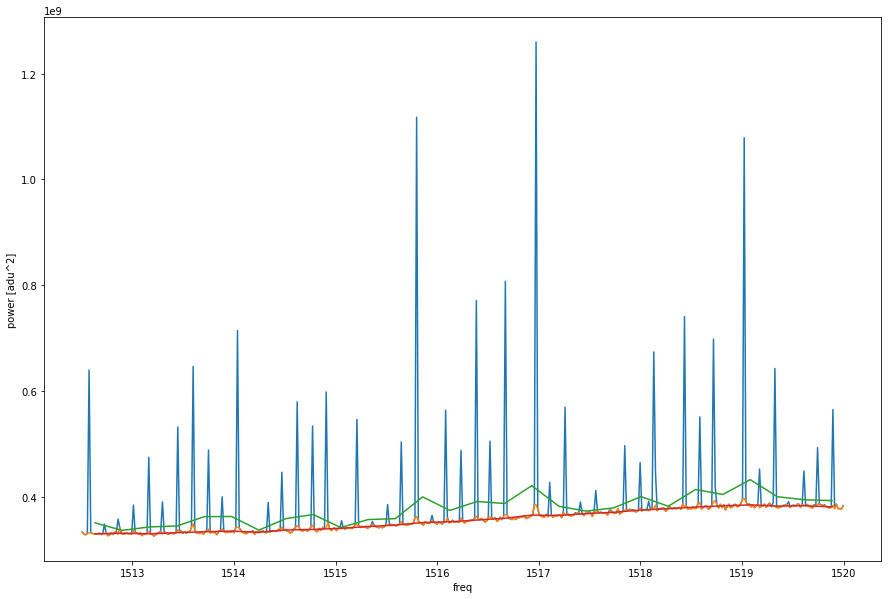

In [108]:
plt.figure(figsize=(15,10))
for fftavg in [512,8192]:
    freqk,ps=getPS(da,ndxmax=64,fftavg=fftavg,numin=numin,numax=numax)
    freqk,psk=getPS(da,ndxmax=64,fftavg=fftavg,numin=numin,numax=numax,killspikes=True)
    plt.plot(freqk,ps.mean(axis=0))
    plt.plot(freqk,psk.mean(axis=0))
plt.xlabel('freq')
plt.ylabel('power [adu^2]')
plt.savefig('spikes1.png')

In [109]:
freqk,ps=getPS(da,ndxmax=64,fftavg=fftavg,numin=1100,numax=1550)
freqk,psk=getPS(da,ndxmax=64,fftavg=fftavg,numin=1100,numax=1550,killspikes=True)

   Frequencies 1100.000000 - 1550.000000 Mhz appear as 0.000000 - 450.000000 

   Frequencies 1100.000000 - 1550.000000 Mhz appear as 0.000000 - 450.000000 

Killed: 700789/13729792 = 5.104149 %
Killed: 708161/13729792 = 5.157842 %
Killed: 681861/13729792 = 4.966288 %
Killed: 628189/13729792 = 4.575372 %
Killed: 703208/13729792 = 5.121767 %
Killed: 708118/13729792 = 5.157529 %
Killed: 659611/13729792 = 4.804232 %
Killed: 617963/13729792 = 4.500891 %
Killed: 712502/13729792 = 5.189460 %
Killed: 700604/13729792 = 5.102801 %
Killed: 646126/13729792 = 4.706014 %
Killed: 662378/13729792 = 4.824385 %
Killed: 702110/13729792 = 5.113770 %
Killed: 696416/13729792 = 5.072298 %
Killed: 673292/13729792 = 4.903876 %
Killed: 625043/13729792 = 4.552458 %
Killed: 716041/13729792 = 5.215236 %
Killed: 713465/13729792 = 5.196473 %
Killed: 685752/13729792 = 4.994628 %
Killed: 635670/13729792 = 4.629859 %
Killed: 647774/13729792 = 4.718018 %
Killed: 704089/13729792 = 5.128184 %
Killed: 712403/13729792 = 5.

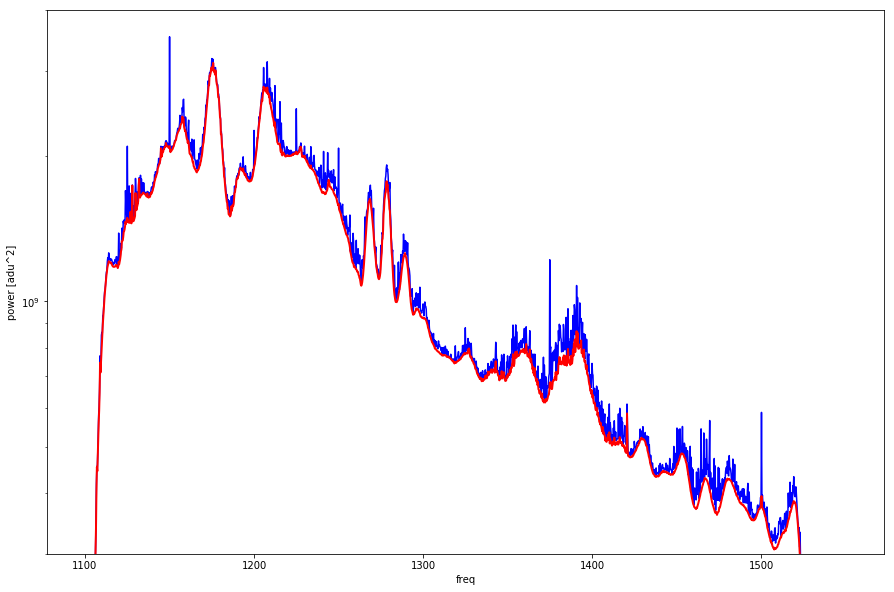

In [110]:
plt.figure(figsize=(15,10))
bad=ps.mean(axis=0)
good=psk.mean(axis=0)
plt.plot(freqk,bad,'b-')
plt.plot(freqk,good,'r-',lw=2)
plt.ylim(3e8,4e9)
plt.semilogy()
plt.xlabel('freq')
plt.ylabel('power [adu^2]')
plt.savefig('spikes2.png')

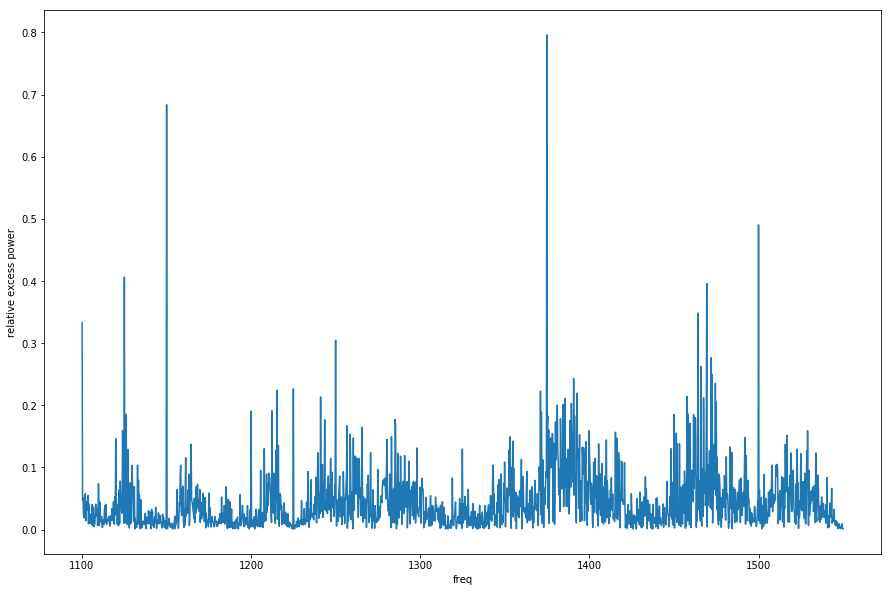

In [111]:
plt.figure(figsize=(15,10))
plt.plot(freqk,(bad-good)/good)
plt.xlabel('freq')
plt.ylabel('relative excess power')
plt.savefig('spikes3.png')

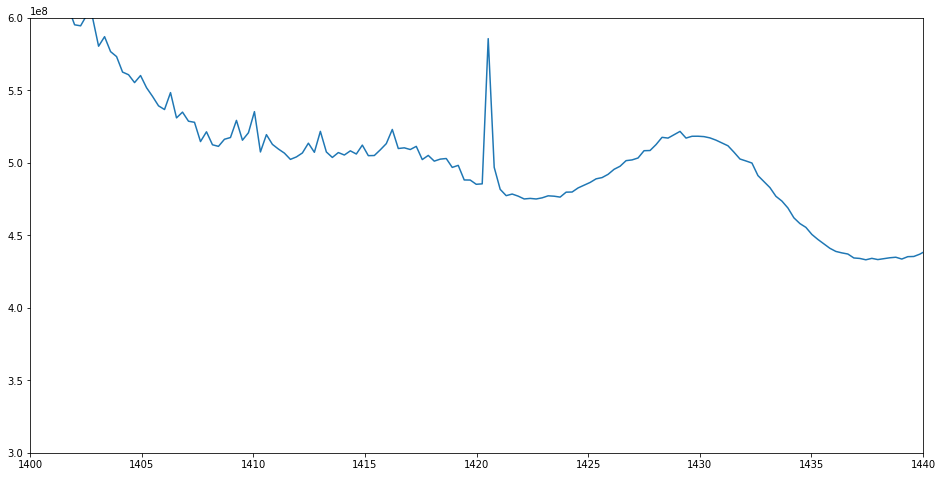

In [128]:
plt.figure(figsize=(16,8))
plt.plot(freqk,good)
plt.xlim(1400,1440)
plt.ylim(0.3e9,0.6e9)
plt.savefig('spikes4.png')